# 4. Age, Hours Per Week, and Education

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shelve
import os
import scipy.stats as stats
from itertools import combinations

plt.style.use('seaborn-dark')

In [2]:
clean_adult = pd.read_hdf('results/df1.h5', 'clean_adult/')
clean_adult.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
1,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
2,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
3,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
4,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K


In [3]:
# %load two_sample_t_test.py
def two_sample_t_test(group1, group2, group1_name, group2_name, alpha = 0.05):
    """Performs a two-sided two sample t-test to see if there is a difference in mean between
    the value of two groups. 
    
    Parameters
    ----------
    group1: Data for the first group. Can be list or array
    group2: Data for the second group. Can be list or array
    group1_name: Name of first group
    group2_name: Name of second group
    alpha: Significance level, default of 0.05 (Although this is very arbitrary as we saw in this class)
    
    
    Return
    ------
    (t, p, reject)
    t: the t-statistic
    p: the p-value
    reject: whether we reject the null hypothesis
    
    Example
    -------
    
    >>> group1 = [1, 2, 3]
    ... group2 = [1, 2, 3]
    ... two_sample_t_test(group1, group2, "group1", "group2")
    There is no statistically significant difference between Group group1 and Group group2
    (0.0, 1.0)    
    """    
        
    n1 = len(group1)
    n2 = len(group2)
    assert(n1 > 0)
    assert(n2 > 0)
    s12 = np.var(group1)
    s22 = np.var(group2)
    m1 = np.mean(group1)
    m2 = np.mean(group2)
    se = np.sqrt((s12/n1) + (s22/n2))
    df = (np.square(s12/n1 + s22/n2) / (( np.square(s12 / n1) / (n1 - 1) ) + (np.square(s22 / n2) / (n2 - 1)))).astype(int)
    t = ((m1 - m2)) / se
    p = stats.t.sf(np.abs(t), df)*2
    if (p < alpha):
        print("The mean difference is statistically significant for Group "  + group1_name +" and Group " + group2_name)
        print("p-value is " + str(p))
        print()
    else:
        print("There is no statistically significant difference between Group " + group1_name +" and Group " + group2_name)
        print()
    return (t, p, p < alpha)

Let us first see if there is a relationship between years of education and age. Intuitively, we would think that there should be no correlation, as most individuals would have completed their education in their early 20s. 

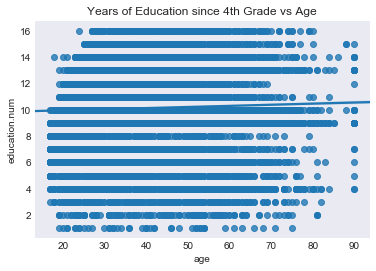

In [4]:
ax = sns.regplot(x = "age", y = "education.num", data=clean_adult);
ax.set_title("Years of Education since 4th Grade vs Age");
plt.savefig("fig/education_age.png")

This is what we expected. There is basically no trend. 

What about the relationship between hours worked per week and age? We think there might be a negative relationship, as younger people tend to have the capacity and motivation to work longer hours. There might also be a downward quadratic relationship, in which people in their middle ages work the hardest. In either case, we definitely do not think that the elderly work the most. 

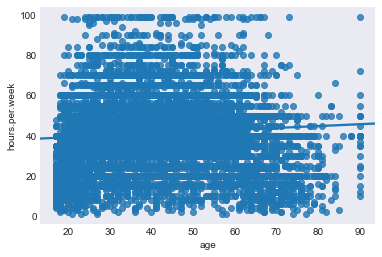

In [5]:
sns.regplot(x="age", y="hours.per.week", data=clean_adult);
ax.set_title("Hours worked per week vs Age");
plt.savefig("fig/hours_age.png")

This result is rather surprising. There seems to be no, or even a somewhat positive trend, between the number of hours worked and age. This is very counterintuitive. It is possible that the occupation itself determines the number of hours worked. We do see that the higher the age, the fewer data points above 60. 

This brings up a question. How are so many individuals working 60 hours or above? There are even many individuals working around 100 hours! That is absurd. Let's look more deeply into this.


In [6]:
clean_adult["hours.per.week"].mean()

40.931237981566213

The average hours worked is 40 hours, which is perfectly normal.

In [7]:
overworked = clean_adult[clean_adult["hours.per.week"] > 60]
overworked.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
12,45,Private,172822,11th,7,Divorced,Transport-moving,Not-in-family,White,Male,0,2824,76,United-States,>50K
23,38,Private,175360,10th,6,Never-married,Prof-specialty,Not-in-family,White,Male,0,2559,90,United-States,>50K
38,48,Private,121253,Bachelors,13,Married-spouse-absent,Sales,Unmarried,White,Female,0,2472,70,United-States,>50K
42,50,Private,237729,HS-grad,9,Widowed,Sales,Not-in-family,White,Female,0,2444,72,United-States,>50K
51,43,Private,155106,Assoc-acdm,12,Divorced,Craft-repair,Not-in-family,White,Male,0,2444,70,United-States,>50K


The first rows all have the individual's marital status as not being in a family or unmarried. Let's look at the relationship between number of hours worked and marital status for both the overall dataset and the overworked individuals.

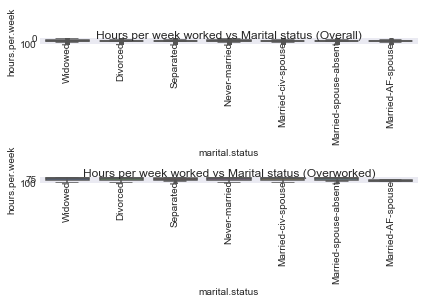

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1)
ax = sns.boxplot(x="marital.status", y="hours.per.week", data = clean_adult, palette="muted", ax= axes[0])
ax.set_title("Hours per week worked vs Marital status (Overall)")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

ax2 = sns.boxplot(x="marital.status", y="hours.per.week", data = overworked, palette="muted", ax = axes[1])
ax2.set_title("Hours per week worked vs Marital status (Overworked)")
ax2.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.savefig("fig/marital_hours")
            
plt.tight_layout()

There is a clear difference between hours worked and marital status for the overall dataset. Widowed individuals seem to work the fewest number of hours. This is understandable. We thought that married individuals would work fewer hours than non-married individuals since these married individuals would have family commitments, but the reverse is true. Maybe married individuals work more to get more pay to support their family?

For the overworked individuals, in the most cases, there does not seem to be a relationship between hours worked and marital status. For overworked individuals, those in the army had the highest average number of hours worked. It is not surprising that those who are working in the army work the longest. Serving our country is a hard job. 

In [10]:
print("Overall")
print()
marital = clean_adult.groupby("marital.status")
pairs = [",".join(map(str, comb)).split(",") for comb in combinations(marital.groups.keys(), 2)]
for pair in pairs:
    marital1_name = pair[0]
    marital2_name = pair[1]
    marital1 = marital.get_group(pair[0])
    marital2 = marital.get_group(pair[1])
    two_sample_t_test(marital1["education.num"], marital2["education.num"], marital1_name, marital2_name)

Overall

There is no statistically significant difference between Group Divorced and Group Married-AF-spouse

The mean difference is statistically significant for Group Divorced and Group Married-civ-spouse
p-value is 9.92127443037e-11

The mean difference is statistically significant for Group Divorced and Group Married-spouse-absent
p-value is 4.28762923945e-07

There is no statistically significant difference between Group Divorced and Group Never-married

The mean difference is statistically significant for Group Divorced and Group Separated
p-value is 2.89413509879e-15

The mean difference is statistically significant for Group Divorced and Group Widowed
p-value is 1.45705330574e-18

There is no statistically significant difference between Group Married-AF-spouse and Group Married-civ-spouse

The mean difference is statistically significant for Group Married-AF-spouse and Group Married-spouse-absent
p-value is 0.0191329987561

There is no statistically significant difference betwe

In [10]:
print("Overworked")
print()
marital = overworked.groupby("marital.status")
pairs = [",".join(map(str, comb)).split(",") for comb in combinations(marital.groups.keys(), 2)]
for pair in pairs:
    marital1_name = pair[0]
    marital2_name = pair[1]
    marital1 = marital.get_group(pair[0])
    marital2 = marital.get_group(pair[1])
    two_sample_t_test(marital1["education.num"], marital2["education.num"], marital1_name, marital2_name)

Overworked

The mean difference is statistically significant for Group Divorced and Group Married-AF-spouse
p-value is 1.05427666912e-06

There is no statistically significant difference between Group Divorced and Group Married-civ-spouse

There is no statistically significant difference between Group Divorced and Group Married-spouse-absent

There is no statistically significant difference between Group Divorced and Group Never-married

There is no statistically significant difference between Group Divorced and Group Separated

There is no statistically significant difference between Group Divorced and Group Widowed

The mean difference is statistically significant for Group Married-AF-spouse and Group Married-civ-spouse
p-value is 4.02476628356e-43

There is no statistically significant difference between Group Married-AF-spouse and Group Married-spouse-absent

The mean difference is statistically significant for Group Married-AF-spouse and Group Never-married
p-value is 7.2324374931

Does occupation play a role in working so many hours?

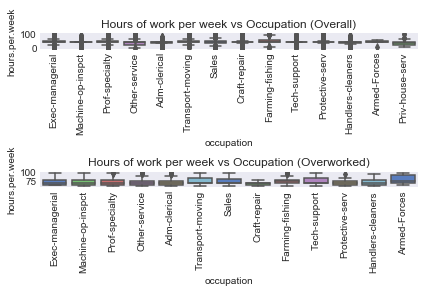

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1)

ax = sns.boxplot(x="occupation", y="hours.per.week", data = clean_adult, palette="muted", ax = axes[0])
ax.set_title("Hours of work per week vs Occupation (Overall)")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

ax2 = sns.boxplot(x="occupation", y="hours.per.week", data = overworked, palette="muted", ax = axes[1])
ax2.set_title("Hours of work per week vs Occupation (Overworked)")
ax2.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.savefig("fig/hours_occupation.png")
plt.tight_layout()

Overall, it seems like farmers and fishers work the most. These are not that surprising: Farming and fishing are very hard and take a long time. We need to be more appreciative of these occupations for their hardwork. On the other hand, other services and private house services occupations work the least. 

For overworked individuals, farmers/fishers and armed forces worked the most, which is what we saw before. Transportation/moving, sales, and tech-support also work quite a lot. 

In [12]:
print("Overall")
print()
occupations = clean_adult.groupby("occupation")
pairs = [",".join(map(str, comb)).split(",") for comb in combinations(occupations.groups.keys(), 2)]
for pair in pairs:
    occ1_name = pair[0]
    occ2_name = pair[1]
    occ1 = occupations.get_group(pair[0])
    occ2 = occupations.get_group(pair[1])
    two_sample_t_test(occ1["education.num"], occ2["education.num"], occ1_name, occ2_name)

Overall

There is no statistically significant difference between Group Adm-clerical and Group Armed-Forces

The mean difference is statistically significant for Group Adm-clerical and Group Craft-repair
p-value is 5.16843274152e-117

The mean difference is statistically significant for Group Adm-clerical and Group Exec-managerial
p-value is 6.34839466192e-192

The mean difference is statistically significant for Group Adm-clerical and Group Farming-fishing
p-value is 9.76369370706e-54

The mean difference is statistically significant for Group Adm-clerical and Group Handlers-cleaners
p-value is 3.00471839723e-115

The mean difference is statistically significant for Group Adm-clerical and Group Machine-op-inspct
p-value is 3.1919131942e-156

The mean difference is statistically significant for Group Adm-clerical and Group Other-service
p-value is 5.10573246515e-154

The mean difference is statistically significant for Group Adm-clerical and Group Priv-house-serv
p-value is 2.195767520

In [13]:
print("Overworked")
print()
occupations = overworked.groupby("occupation")
pairs = [",".join(map(str, comb)).split(",") for comb in combinations(occupations.groups.keys(), 2)]
for pair in pairs:
    occ1_name = pair[0]
    occ2_name = pair[1]
    occ1 = occupations.get_group(pair[0])
    occ2 = occupations.get_group(pair[1])
    two_sample_t_test(occ1["education.num"], occ2["education.num"], occ1_name, occ2_name)

Overworked

There is no statistically significant difference between Group Adm-clerical and Group Craft-repair

The mean difference is statistically significant for Group Adm-clerical and Group Exec-managerial
p-value is 0.0112680181374

There is no statistically significant difference between Group Adm-clerical and Group Farming-fishing

There is no statistically significant difference between Group Adm-clerical and Group Handlers-cleaners

There is no statistically significant difference between Group Adm-clerical and Group Machine-op-inspct

The mean difference is statistically significant for Group Adm-clerical and Group Other-service
p-value is 0.0434003758251

There is no statistically significant difference between Group Adm-clerical and Group Priv-house-serv

The mean difference is statistically significant for Group Adm-clerical and Group Prof-specialty
p-value is 1.48302767929e-10

There is no statistically significant difference between Group Adm-clerical and Group Protectiv